In [2]:
import pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import friedmanchisquare, rankdata
from scipy.stats import rankdata
from tabulate import tabulate

from pathlib import Path

warnings.filterwarnings("ignore")

# **Variables**

In [3]:
METRICS_DIR = Path("../results/metrics")
PLOTS_DIR = Path("../results/plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
# Definir estilos de modelos
model_styles = {
    # Recurrentes base (líneas punteadas)
    "RNN": {"linestyle": "--", "marker": "o", "linewidth": 2, "markersize": 7},
    "GRU": {"linestyle": "--", "marker": "o", "linewidth": 2, "markersize": 7},
    "LSTM": {"linestyle": "--", "marker": "o", "linewidth": 2, "markersize": 7},
    # RFF (líneas sólidas)
    "RFF_RNN": {"linestyle": "-", "marker": "s", "linewidth": 2.5, "markersize": 7},
    "RFF_GRU": {"linestyle": "-", "marker": "s", "linewidth": 2.5, "markersize": 7},
    "RFF_LSTM": {"linestyle": "-", "marker": "s", "linewidth": 2.5, "markersize": 7},
    # Transformers (líneas punto-guion)
    "Transformer": {"linestyle": "-.", "marker": "D", "linewidth": 2, "markersize": 6},
    "Autoformer": {"linestyle": "-.", "marker": "D", "linewidth": 2, "markersize": 6},
    "FEDformer": {"linestyle": "-.", "marker": "D", "linewidth": 2, "markersize": 6}
}

In [5]:
colormaps = {
    "R2": "viridis",
    "MAE": "Oranges_r",
    "RMSE": "Blues_r"
}

all_models = [
    "RNN", "RFF_RNN", 
    "GRU", "RFF_GRU", 
    "LSTM", "RFF_LSTM",
    "Transformer", "Autoformer", "FEDformer"
]

# **Synthetic dataset**

In [6]:
dataset_name = "Synthetic"
dataframes_to_combine = []

# 1. Cargar modelos RNN/RFF
file_rnn = METRICS_DIR / f"results_{dataset_name}.pkl"
if file_rnn.exists():
    with open(file_rnn, "rb") as f:
        data_rnn = pickle.load(f)
    
    if "global" in data_rnn and "pointwise_all" in data_rnn["global"]:
        df_rnn = data_rnn["global"]["pointwise_all"].copy()
        dataframes_to_combine.append(df_rnn)
else:
    print(f"⚠️  Archivo no encontrado: {file_rnn.name}")

# 2. Cargar modelos Transformer
file_trafo = METRICS_DIR / f"results_TRAFO_{dataset_name}.pkl"
if file_trafo.exists():
    with open(file_trafo, "rb") as f:
        data_trafo = pickle.load(f)
    
    if "global" in data_trafo and "pointwise_all" in data_trafo["global"]:
        df_trafo = data_trafo["global"]["pointwise_all"].copy()
        dataframes_to_combine.append(df_trafo)
else:
    print(f"⚠️  Archivo no encontrado: {file_trafo.name}")

# 3. Combinar datos
if dataframes_to_combine:
    df_synthetic = pd.concat(dataframes_to_combine, ignore_index=True)
    
    # Calcular medias acumulativas
    df_synthetic_cumulative = (
        df_synthetic.sort_values(["model", "horizon"])
        .groupby("model", group_keys=False)
        .apply(lambda g: g.assign(
            R2=g["R2"].expanding().mean(),
            MAE=g["MAE"].expanding().mean(),
            RMSE=g["RMSE"].expanding().mean()
        ))
    )
    
else:
    raise ValueError("No se pudieron cargar datos del dataset Synthetic")

print("="*80)

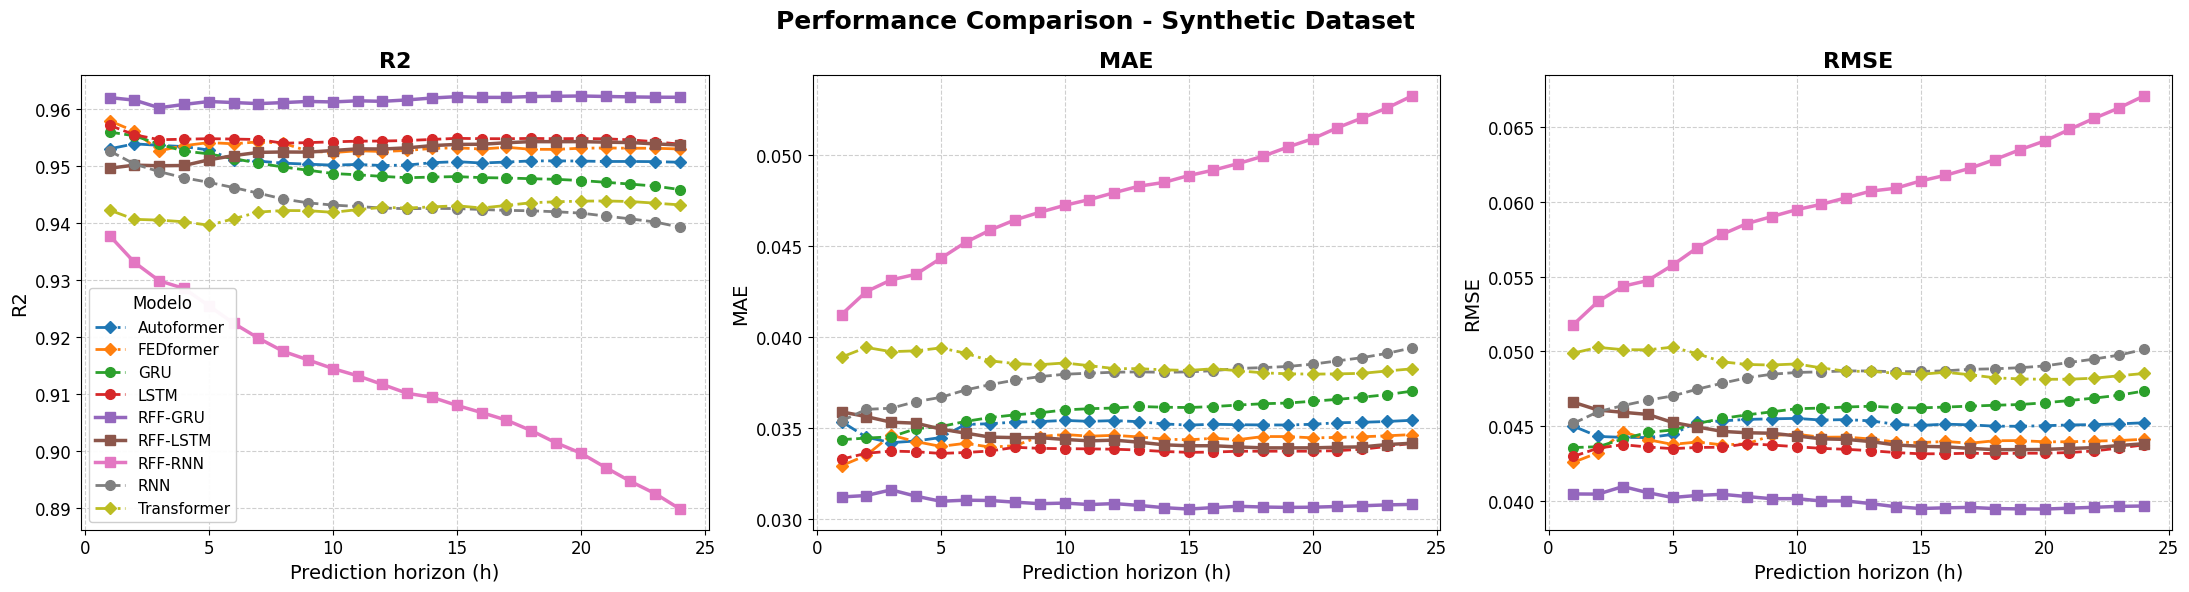

✅ Guardado: performance_lines_Synthetic.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.3)

for i, metric in enumerate(["R2", "MAE", "RMSE"]):
    ax = axes[i]
    
    # Plotear cada modelo
    for model_name in df_synthetic_cumulative["model"].unique():
        subset = df_synthetic_cumulative[df_synthetic_cumulative["model"] == model_name]
        
        if not subset.empty:
            style = model_styles.get(model_name, {
                "linestyle": "-", 
                "marker": "o", 
                "linewidth": 2,
                "markersize": 6
            })
            
            label = model_name.replace("_", "-")
            
            ax.plot(
                subset["horizon"],
                subset[metric],
                label=label,
                **style
            )
    
    # Configuración
    ax.set_title(metric, fontsize=16, fontweight="bold")
    ax.set_xlabel("Prediction horizon (h)", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.tick_params(axis='both', labelsize=12)
    
    # Leyenda solo en el primer subplot
    if i == 0:
        ax.legend(title="Modelo", fontsize=11, title_fontsize=12, 
                 loc='best', framealpha=0.95)

plt.suptitle(f"Performance Comparison - Synthetic Dataset", 
             fontsize=18, fontweight='bold')
plt.tight_layout()

# Guardar
output_path = PLOTS_DIR / "performance_lines_Synthetic.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Guardado: {output_path.name}")

   R2: 9 modelos, 24 horizontes
   MAE: 9 modelos, 24 horizontes
   RMSE: 9 modelos, 24 horizontes


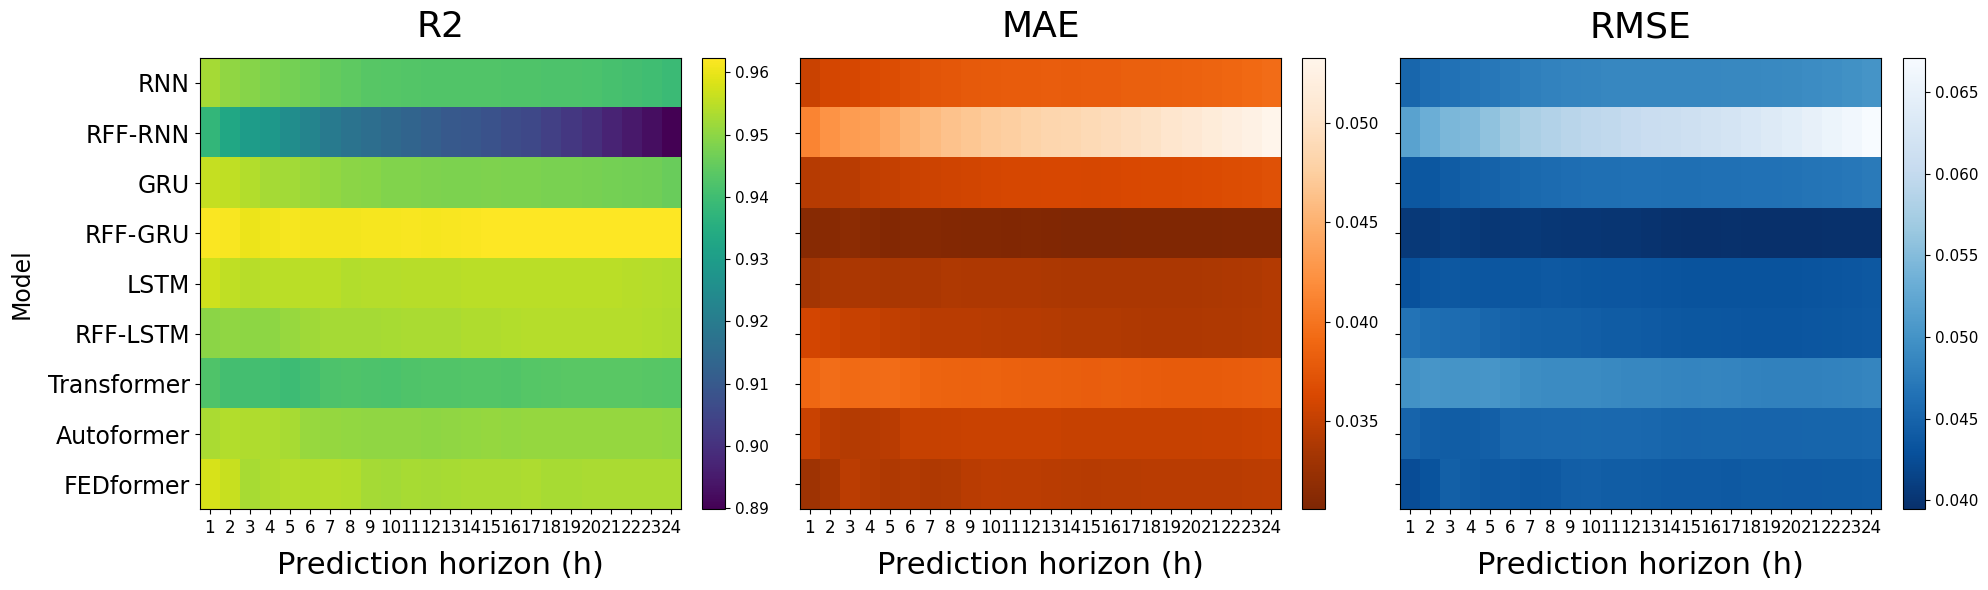


✅ Guardado: heatmap_Synthetic.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.4)

for col_idx, metric in enumerate(["R2", "MAE", "RMSE"]):
    ax = axes[col_idx]
    
    # Crear pivot table
    pivot_data = df_synthetic_cumulative.pivot_table(
        values=metric,
        index="model",
        columns="horizon",
        aggfunc="mean"
    )
    
    # Reordenar modelos
    existing_models = [m for m in all_models if m in pivot_data.index]
    if existing_models:
        pivot_data = pivot_data.reindex(existing_models)
    
    # Heatmap
    im = ax.imshow(
        pivot_data.values,
        aspect='auto',
        cmap=colormaps[metric],
        interpolation='nearest'
    )
    
    # Configurar ticks
    ax.set_xticks(range(len(pivot_data.columns)))
    ax.set_yticks(range(len(pivot_data.index)))
    ax.set_xticklabels(pivot_data.columns, fontsize=12)
    
    # Etiquetas Y: solo en el primer subplot (izquierda)
    if col_idx == 0:
        model_labels = [m.replace("_", "-") for m in pivot_data.index]
        ax.set_yticklabels(model_labels, fontsize=17)
        ax.set_ylabel("Model", fontsize=17, labelpad=10)
    else:
        ax.set_yticklabels([])  # Ocultar etiquetas en los demás subplots
    
    # Títulos y etiquetas
    ax.set_title(metric, fontsize=26, pad=15)
    ax.set_xlabel("Prediction horizon (h)", fontsize=22, labelpad=10)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=11)
    
    print(f"   {metric}: {len(existing_models)} modelos, {len(pivot_data.columns)} horizontes")

#plt.suptitle("Performance Heatmap - Synthetic Dataset", fontsize=18, fontweight='bold')
plt.tight_layout()

# Guardar
output_path = PLOTS_DIR / "heatmap_Synthetic.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Guardado: {output_path.name}")

# **Real dataset**

In [9]:
# Mapeo de nombres
dataset_display_names = {
    "Netherland-0": "Schiphol",
    "Netherland-1": "De Bilt",
    "Netherland-2": "Leeuwarden",
    "Argone": "Argone",
    "Beijing": "Beijing",
    "Chengdu": "Chengdu"
}

metrics = ["R2", "MAE", "RMSE"]
Datasets = ["Argone", "Beijing", "Chengdu", "Netherland-0", "Netherland-1", "Netherland-2"]


📄 Processing: Argone (Argone)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


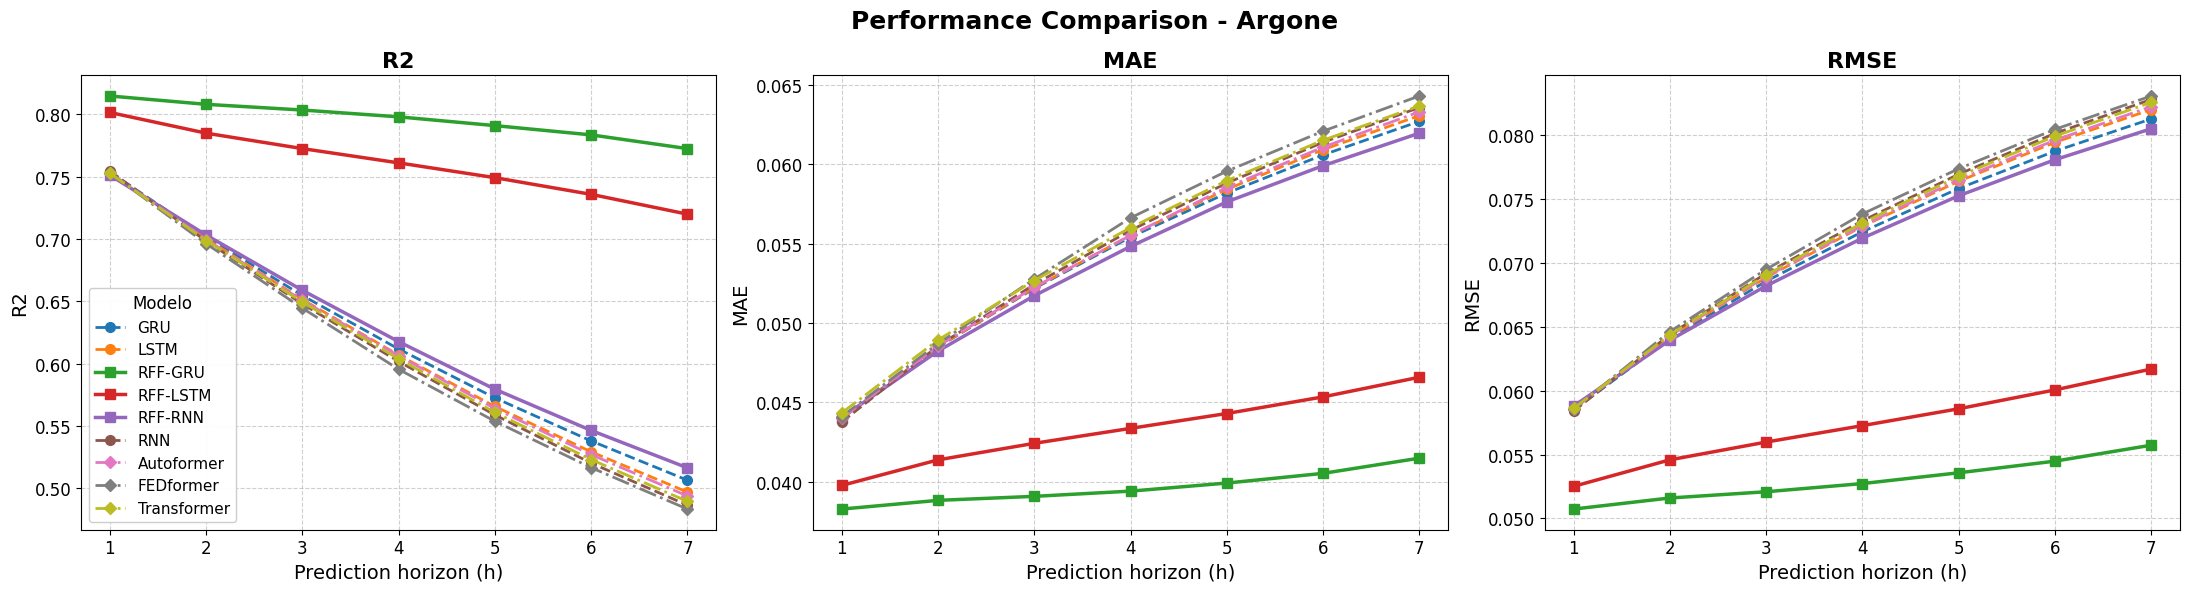


📄 Processing: Beijing (Beijing)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


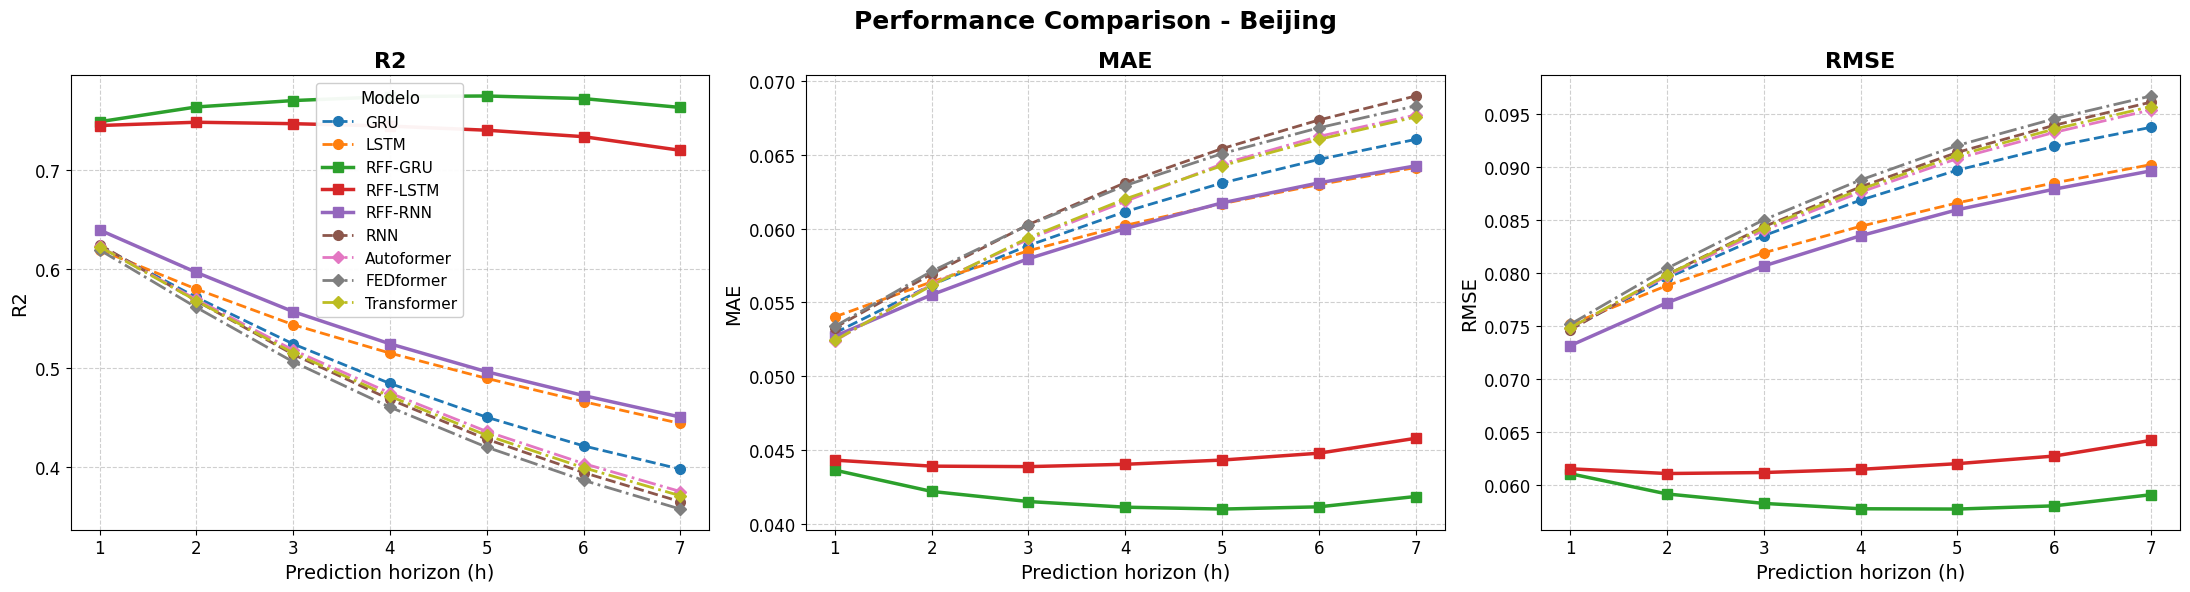


📄 Processing: Chengdu (Chengdu)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


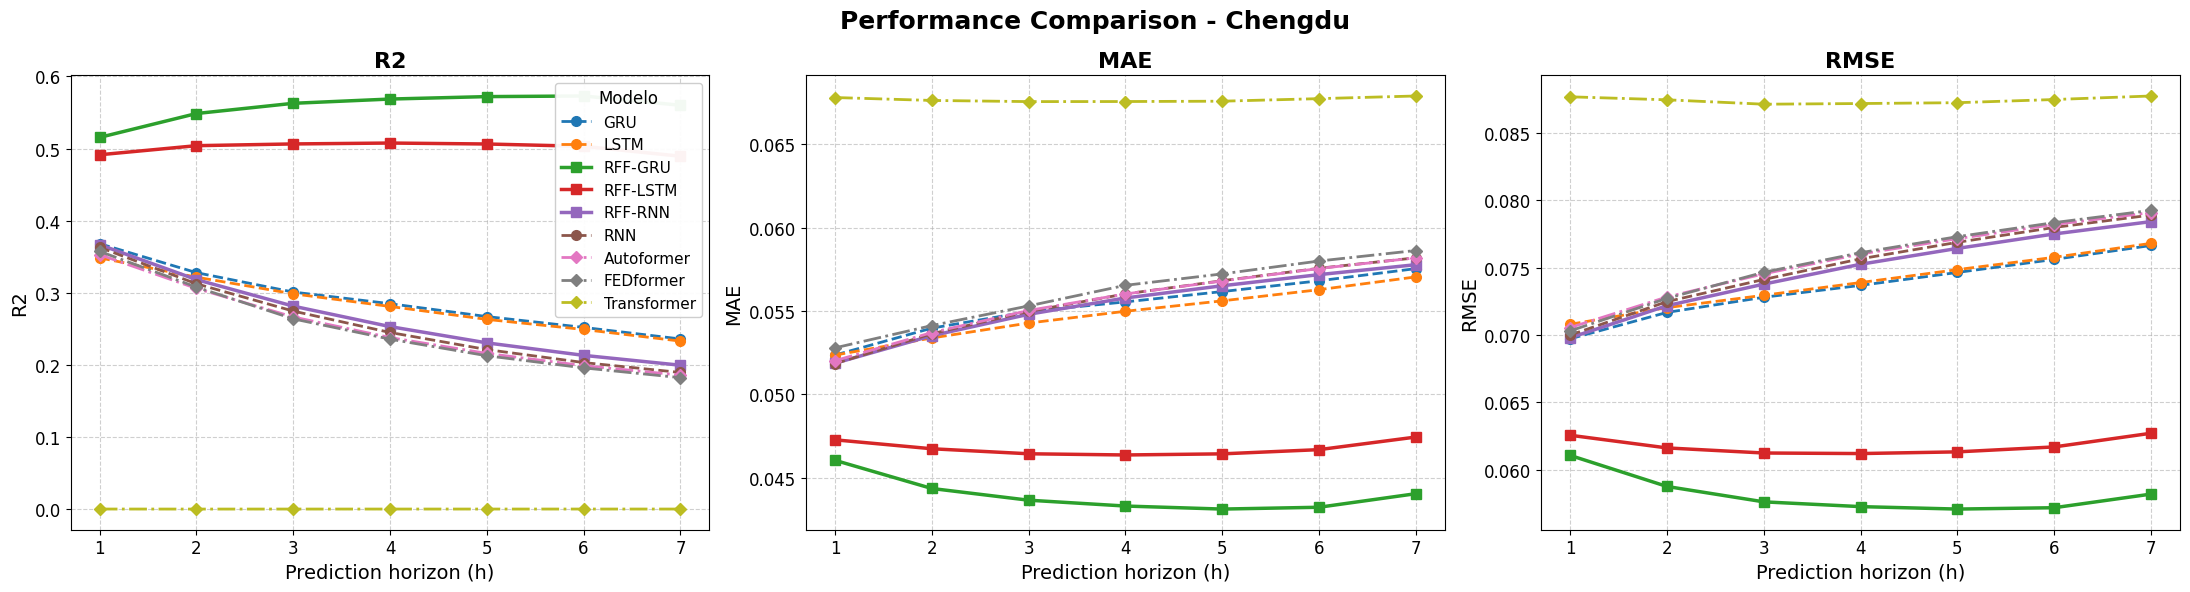


📄 Processing: Schiphol (Netherland-0)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


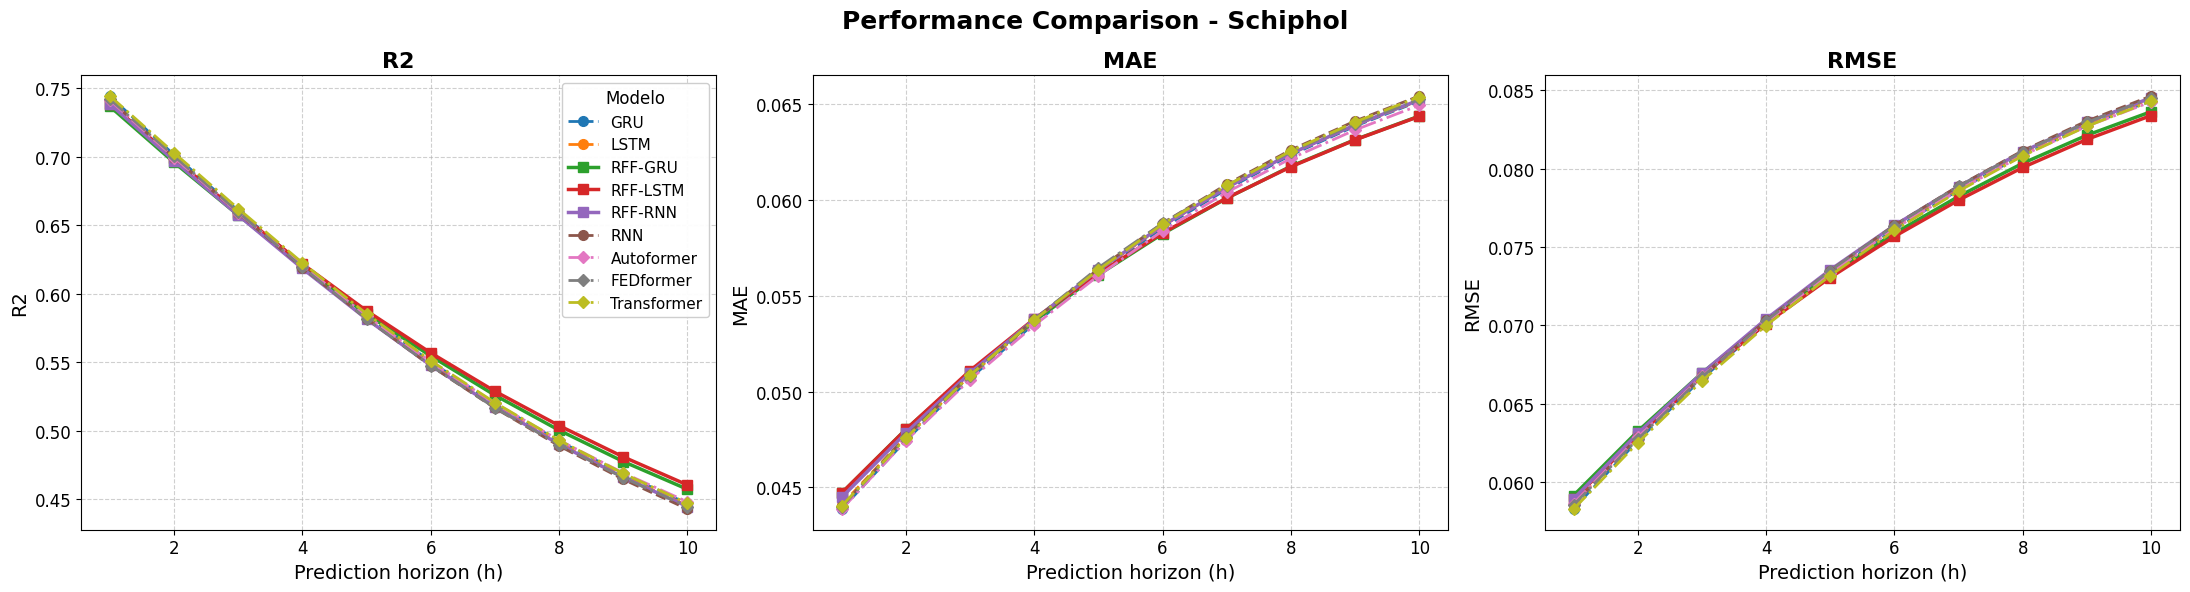


📄 Processing: De Bilt (Netherland-1)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


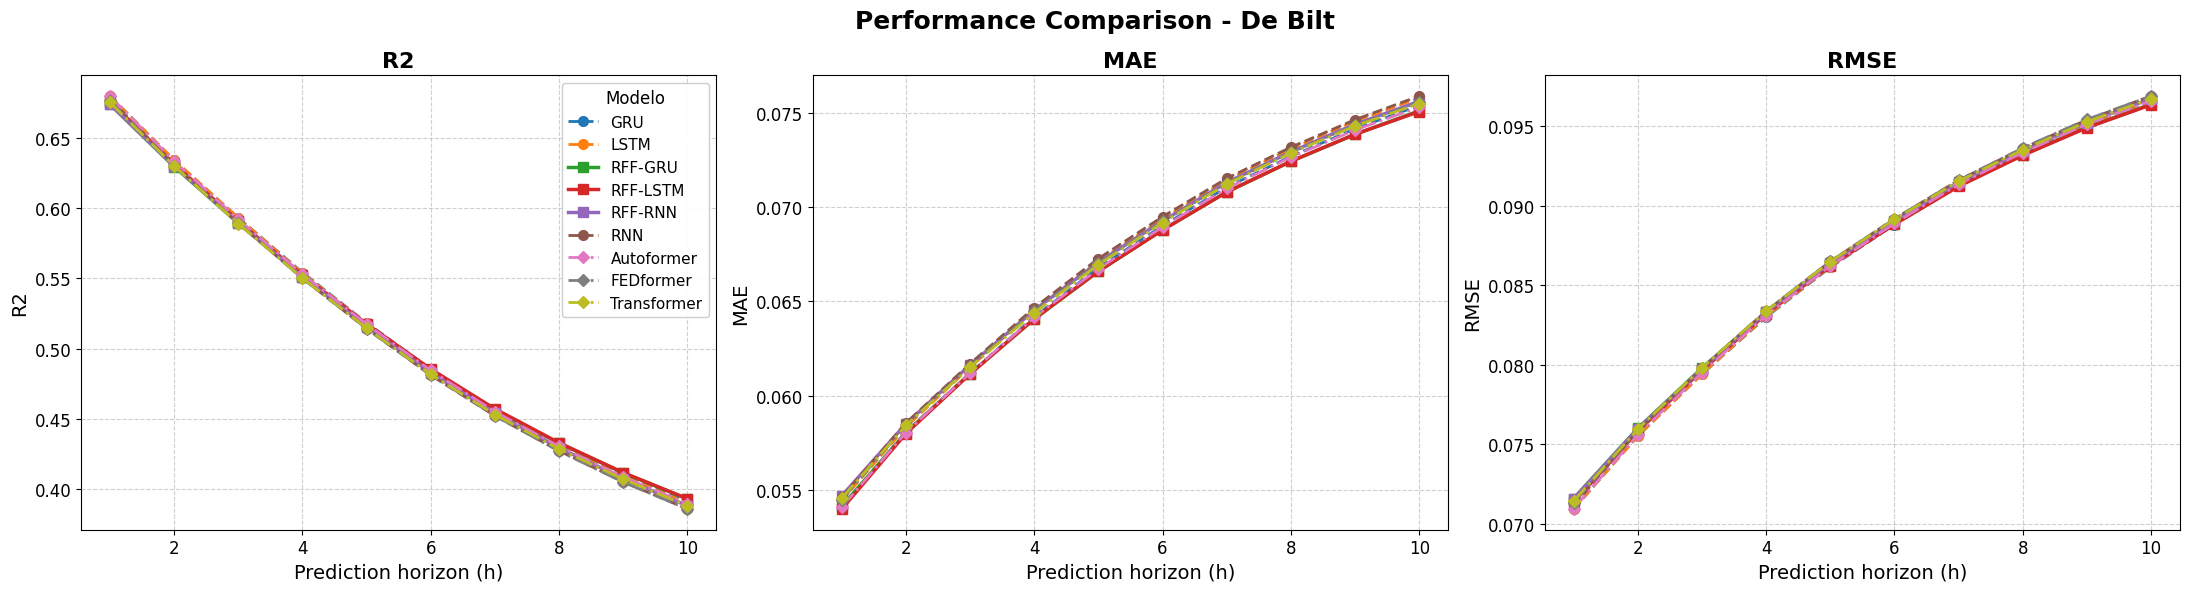


📄 Processing: Leeuwarden (Netherland-2)
   ✓ Loaded Transformers
   Models available: ['GRU', 'LSTM', 'RFF_GRU', 'RFF_LSTM', 'RFF_RNN', 'RNN', 'Autoformer', 'FEDformer', 'Transformer']


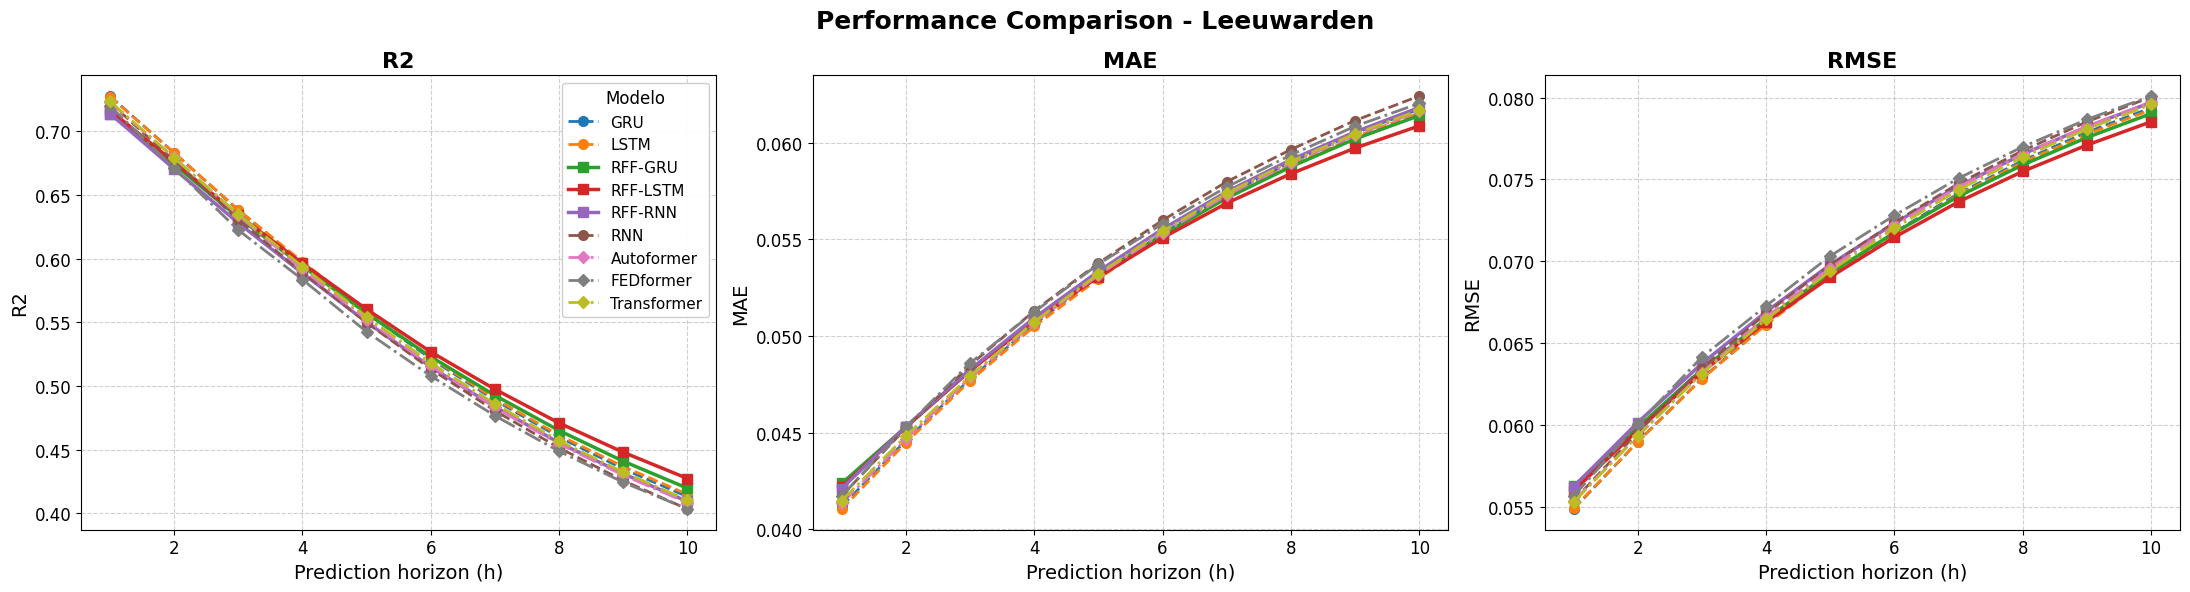

In [ ]:
for data in Datasets:
    display_name = dataset_display_names.get(data, data)
    print(f"\n📄 Processing: {display_name} ({data})")
    
    # Cargar datos RNN
    data_RNN = pickle.load(open(f"../results/metrics/results_{data}.pkl", "rb"))
    
    # Extraer datos de RNN
    df_rnn = data_RNN["global"]["pointwise_all"].copy()
    
    # Calcular medias acumulativas para RNN
    df_rnn_cumulative = (
        df_rnn.sort_values(["model", "horizon"])
        .groupby("model", group_keys=False)
        .apply(lambda g: g.assign(
            R2=g["R2"].expanding().mean(),
            MAE=g["MAE"].expanding().mean(),
            RMSE=g["RMSE"].expanding().mean()
        ))
    )
    
    # Intentar cargar Transformers
    try:
        data_TRAFO = pickle.load(open(f"../results/metrics/results_TRAFO_{data}.pkl", "rb"))
        df_trafo = data_TRAFO["global"]["pointwise_all"].copy()
        
        df_trafo_cumulative = (
            df_trafo.sort_values(["model", "horizon"])
            .groupby("model", group_keys=False)
            .apply(lambda g: g.assign(
                R2=g["R2"].expanding().mean(),
                MAE=g["MAE"].expanding().mean(),
                RMSE=g["RMSE"].expanding().mean()
            ))
        )
        
        # Combinar ambos DataFrames
        df_combined = pd.concat([df_rnn_cumulative, df_trafo_cumulative], ignore_index=True)
        print(f"   ✓ Loaded Transformers")
        
    except FileNotFoundError:
        print(f"   ⚠️  No Transformer data found, using only RNN models")
        df_combined = df_rnn_cumulative
    
    print(f"   Models available: {list(df_combined['model'].unique())}")
    
    # ==========================================
    # 3. CREAR GRÁFICA
    # ==========================================
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    plt.subplots_adjust(wspace=0.3)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Plotear cada modelo
        for model_name in df_combined["model"].unique():
            subset = df_combined[df_combined["model"] == model_name]
            
            if not subset.empty:
                # Obtener estilo del modelo
                style = model_styles.get(model_name, {
                    "linestyle": "-", 
                    "marker": "o", 
                    "linewidth": 2,
                    "markersize": 6
                })
                
                # Label sin guiones bajos
                label = model_name.replace("_", "-")
                
                ax.plot(
                    subset["horizon"],
                    subset[metric],
                    label=label,
                    **style
                )
        
        # Configuración de cada subplot
        ax.set_title(metric, fontsize=16, fontweight="bold")
        ax.set_xlabel("Prediction horizon (h)", fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.tick_params(axis='both', labelsize=12)
        
        # Leyenda solo en el primer subplot
        if i == 0:
            ax.legend(title="Modelo", fontsize=11, title_fontsize=12, 
                     loc='best', framealpha=0.95)
    
    plt.suptitle(f"Performance Comparison - {display_name}", 
                 fontsize=18, fontweight='bold')
    plt.tight_layout()
    
    plt.show()
# Agrupar datasets
groups = {
    "Hourly": ["Argone", "Beijing", "Chengdu"],
    "Netherland": ["Netherland-0", "Netherland-1", "Netherland-2"]
}

# Lista completa de modelos (orden de visualización)
all_models = [
    "RNN", "RFF_RNN", 
    "GRU", "RFF_GRU", 
    "LSTM", "RFF_LSTM",
    "Transformer", "Autoformer", "FEDformer"
]

# Colormaps para cada métrica
colormaps = {
    "R2": "viridis",
    "MAE": "Oranges_r",
    "RMSE": "Blues_r"
}
    

In [11]:
# Agrupar datasets
groups = {
    "Hourly": ["Argone", "Beijing", "Chengdu"],
    "Netherland": ["Netherland-0", "Netherland-1", "Netherland-2"]
}

# Lista completa de modelos (orden de visualización)
all_models = [
    "RNN", "RFF_RNN", 
    "GRU", "RFF_GRU", 
    "LSTM", "RFF_LSTM",
    "Transformer", "Autoformer", "FEDformer"
]

# Colormaps para cada métrica
colormaps = {
    "R2": "viridis",
    "MAE": "Oranges_r",
    "RMSE": "Blues_r"
}



📄 Processing: Argone
   ✓ Loaded RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Loaded Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined dataset with 9 models

📄 Processing: Beijing
   ✓ Loaded RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Loaded Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined dataset with 9 models

📄 Processing: Chengdu
   ✓ Loaded RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Loaded Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined dataset with 9 models

📄 Processing: Netherland-0
   ✓ Loaded RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Loaded Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined dataset with 9 models

📄 Processing: Netherland-1
   ✓ Loaded RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Loaded Transformer mod

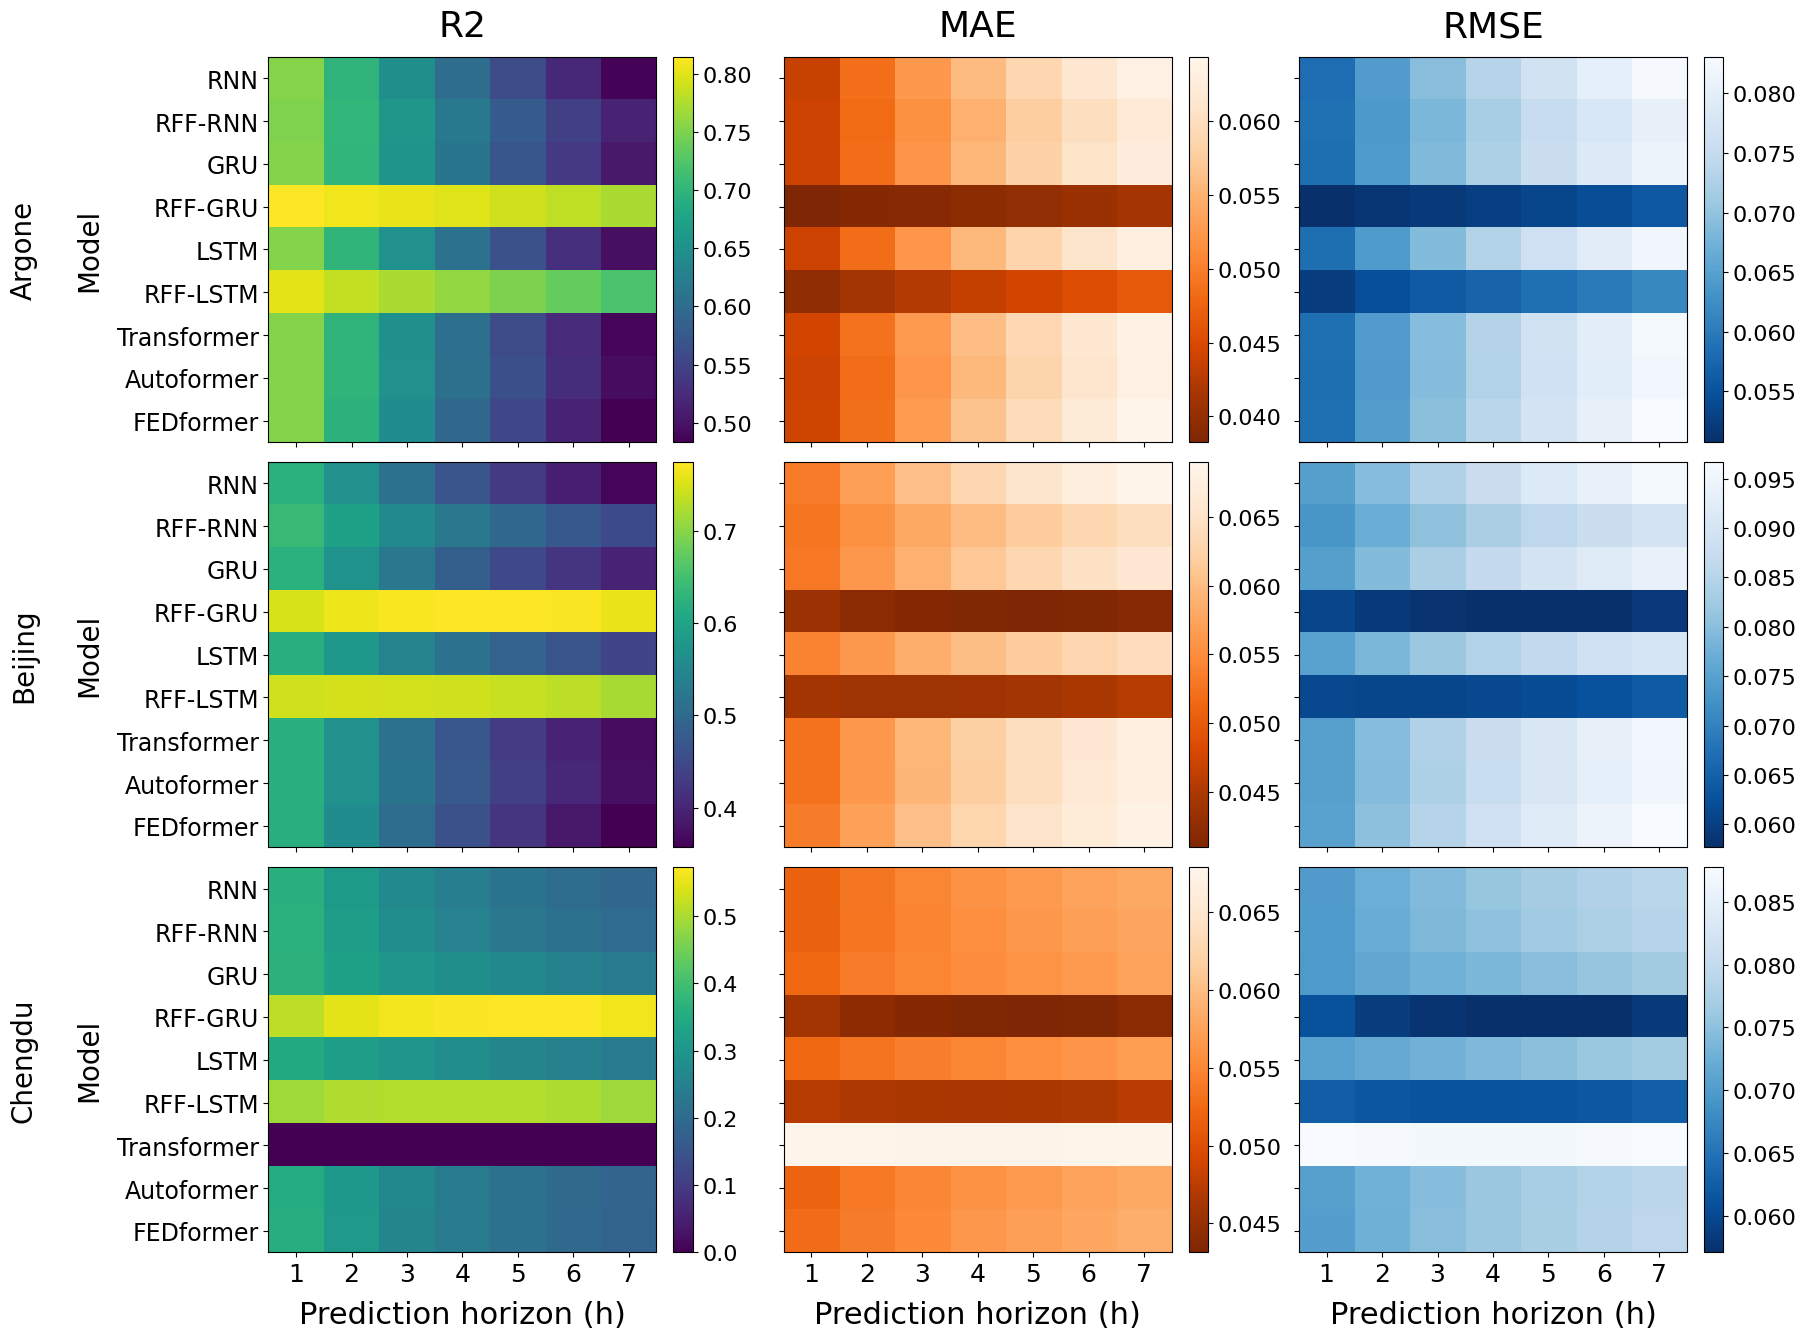

   ✅ Saved: cumulative_heatmap_Hourly.png

   Processing: Netherland-0
      R2: 9 models, 10 horizons
      MAE: 9 models, 10 horizons
      RMSE: 9 models, 10 horizons
   Processing: Netherland-1
      R2: 9 models, 10 horizons
      MAE: 9 models, 10 horizons
      RMSE: 9 models, 10 horizons
   Processing: Netherland-2
      R2: 9 models, 10 horizons
      MAE: 9 models, 10 horizons
      RMSE: 9 models, 10 horizons


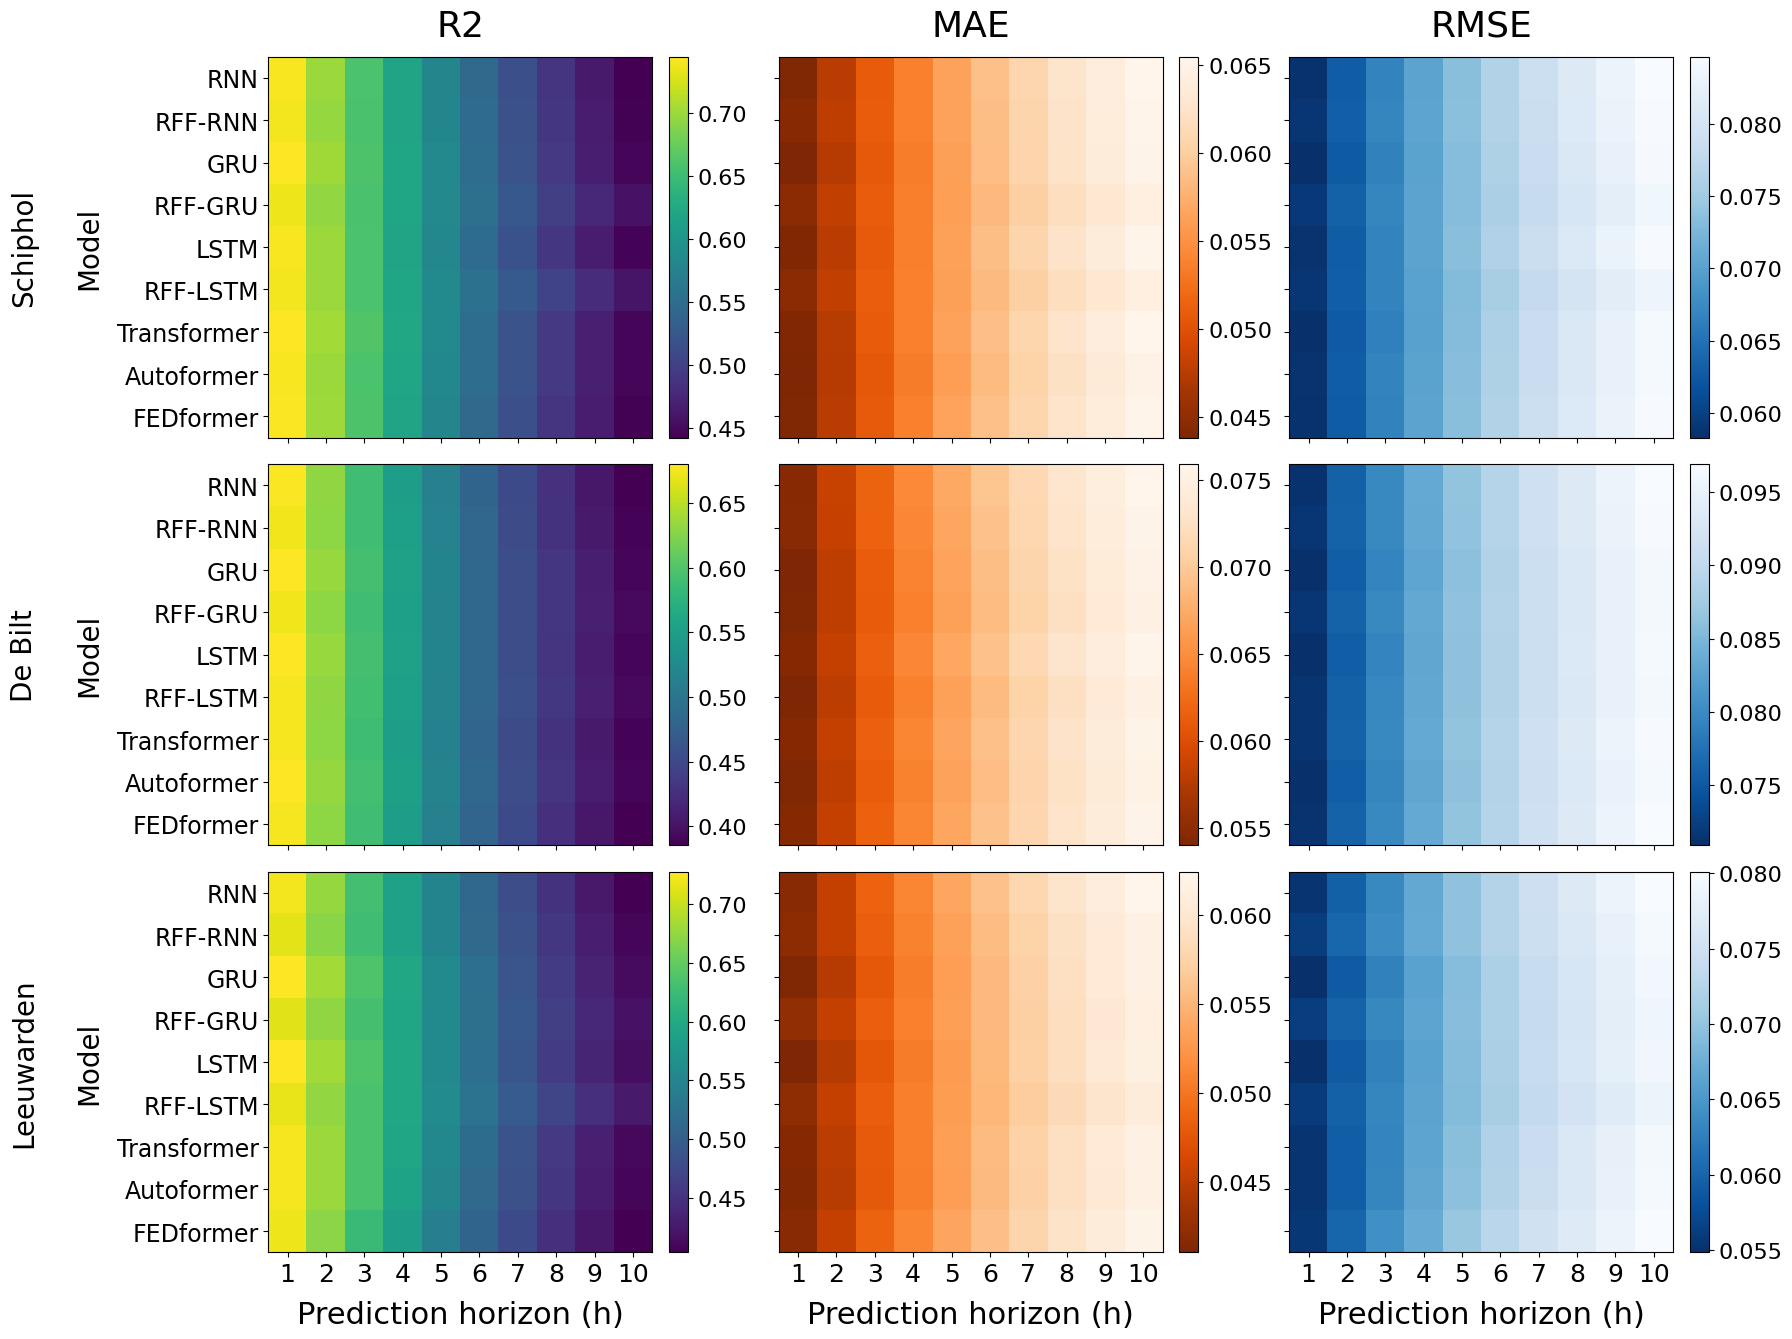

   ✅ Saved: cumulative_heatmap_Netherland.png


✅ All heatmap figures generated successfully!
📁 Saved to: ../results/plots


In [12]:

all_datasets = {}
dataset_list = ["Argone", "Beijing", "Chengdu", "Netherland-0", "Netherland-1", "Netherland-2"]

for dataset_name in dataset_list:
    
    print(f"\n📄 Processing: {dataset_name}")
    
    dataframes_to_combine = []
    
    # 1. Cargar archivo RNN/RFF
    file_rnn = METRICS_DIR / f"results_{dataset_name}.pkl"
    if file_rnn.exists():
        with open(file_rnn, "rb") as f:
            file_content = pickle.load(f)
        
        if "global" in file_content and "pointwise_all" in file_content["global"]:
            df_rnn = file_content["global"]["pointwise_all"].copy()
            dataframes_to_combine.append(df_rnn)
            print(f"   ✓ Loaded RNN models: {list(df_rnn['model'].unique())}")
    else:
        print(f"   ⚠️  {file_rnn.name} not found")
    
    # 2. Cargar archivo Transformers
    file_trafo = METRICS_DIR / f"results_TRAFO_{dataset_name}.pkl"
    if file_trafo.exists():
        with open(file_trafo, "rb") as f:
            file_content = pickle.load(f)
        
        if "global" in file_content and "pointwise_all" in file_content["global"]:
            df_trafo = file_content["global"]["pointwise_all"].copy()
            dataframes_to_combine.append(df_trafo)
            print(f"   ✓ Loaded Transformer models: {list(df_trafo['model'].unique())}")
    else:
        print(f"   ⚠️  {file_trafo.name} not found")
    
    # 3. Combinar y calcular medias acumulativas
    if dataframes_to_combine:
        df_combined = pd.concat(dataframes_to_combine, ignore_index=True)
        
        # Calcular medias acumulativas
        df_cumulative = (
            df_combined.sort_values(["model", "horizon"])
            .groupby("model", group_keys=False)
            .apply(lambda g: g.assign(
                R2=g["R2"].expanding().mean(),
                MAE=g["MAE"].expanding().mean(),
                RMSE=g["RMSE"].expanding().mean()
            ))
        )
        
        all_datasets[dataset_name] = df_cumulative
        print(f"   ✅ Combined dataset with {len(df_cumulative['model'].unique())} models")
    else:
        print(f"   ❌ No data found for {dataset_name}")

# ==========================================
# CREAR HEATMAPS POR GRUPO
# ==========================================


for group_name, dataset_list in groups.items():
    
    # Filtrar solo los datasets que existen
    existing_datasets = [ds for ds in dataset_list if ds in all_datasets]
    
    if not existing_datasets:
        print(f"\n⚠️  No data for group: {group_name}")
        continue
    
    n_rows = len(existing_datasets)
    n_cols = len(metrics)
        
    # Crear figura con altura ajustada (más espacio para más modelos)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4.5 * n_rows))
    
    # Asegurar que axes sea 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plt.subplots_adjust(hspace=0.35, wspace=0.4)
    
    for row_idx, dataset_name in enumerate(existing_datasets):
        df_data = all_datasets[dataset_name]
        print(f"   Processing: {dataset_name}")
        
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]
            
            # Crear pivot table
            pivot_data = df_data.pivot_table(
                values=metric,
                index="model",
                columns="horizon",
                aggfunc="mean"
            )
            
            # Reordenar modelos según all_models (solo los que existen)
            existing_models = [m for m in all_models if m in pivot_data.index]
            if existing_models:
                pivot_data = pivot_data.reindex(existing_models)
            
            print(f"      {metric}: {len(existing_models)} models, {len(pivot_data.columns)} horizons")
            
            # Heatmap
            im = ax.imshow(
                pivot_data.values,
                aspect='auto',
                cmap=colormaps[metric],
                interpolation='nearest'
            )
            
            # Configurar ticks
            ax.set_xticks(range(len(pivot_data.columns)))
            ax.set_yticks(range(len(pivot_data.index)))
            
            # ===== ETIQUETAS DEL EJE X (solo última fila) =====
            if row_idx == n_rows - 1:
                ax.set_xticklabels(pivot_data.columns, fontsize=18)
                ax.set_xlabel("Prediction horizon (h)", fontsize=22, labelpad=10)
            else:
                ax.set_xticklabels([])
            
            # ===== ETIQUETAS DEL EJE Y (solo primera columna) =====
            if col_idx == 0:
                # Reemplazar "_" por "-" en los nombres de modelos
                model_labels = [m.replace("_", "-") for m in pivot_data.index]
                ax.set_yticklabels(model_labels, fontsize=17)
                
                # Usar nombre personalizado si existe en el mapeo
                display_name = dataset_display_names.get(dataset_name, dataset_name)
                ax.set_ylabel(f"{display_name}\n\nModel", fontsize=20, labelpad=10)
            else:
                ax.set_yticklabels([])
            
            # ===== TÍTULO (solo primera fila) =====
            if row_idx == 0:
                ax.set_title(metric, fontsize=26, pad=15)
            
            # Colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    
    # Guardar figura
    output_path = PLOTS_DIR / f"cumulative_heatmap_{group_name}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"   ✅ Saved: {output_path.name}\n")

print("\n" + "="*80)
print("✅ All heatmap figures generated successfully!")
print(f"📁 Saved to: {PLOTS_DIR}")
print("="*80)

# **Friedman test**

In [13]:
METRICS_DIR = Path("../results/metrics")
PLOTS_DIR = Path("../results/plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

metrics = ["R2", "MAE", "RMSE"]

dataset_display_names = {
    "Netherland-0": "Schiphol",
    "Netherland-1": "De Bilt",
    "Netherland-2": "Leeuwarden",
    "Argone": "Argone",
    "Beijing": "Beijing",
    "Chengdu": "Chengdu", 
    "Synthetic": "Synthetic"
}

# ==========================================
# PASO 1: CARGAR DATOS
# ==========================================

print("\n🔄 LOADING DATA...")

dataset_list = ["Synthetic", "Argone", "Beijing", "Chengdu", "Netherland-0", "Netherland-1", "Netherland-2"]
all_datasets = {}

for dataset_name in dataset_list:
    print(f"\n📄 {dataset_name}")
    
    dataframes_to_combine = []
    
    # Cargar RNN/RFF
    file_rnn = METRICS_DIR / f"results_{dataset_name}.pkl"
    if file_rnn.exists():
        try:
            with open(file_rnn, "rb") as f:
                content = pickle.load(f)
            if "global" in content and "pointwise_all" in content["global"]:
                df = content["global"]["pointwise_all"].copy()
                dataframes_to_combine.append(df)
                print(f"   ✓ RNN: {len(df['model'].unique())} models")
        except Exception as e:
            print(f"   ❌ Error: {e}")
    
    # Cargar Transformers
    file_trafo = METRICS_DIR / f"results_TRAFO_{dataset_name}.pkl"
    if file_trafo.exists():
        try:
            with open(file_trafo, "rb") as f:
                content = pickle.load(f)
            if "global" in content and "pointwise_all" in content["global"]:
                df = content["global"]["pointwise_all"].copy()
                dataframes_to_combine.append(df)
                print(f"   ✓ Transformers: {len(df['model'].unique())} models")
        except Exception as e:
            print(f"   ❌ Error: {e}")
    
    # Combinar (SIN calcular medias acumulativas todavía)
    if dataframes_to_combine:
        df_combined = pd.concat(dataframes_to_combine, ignore_index=True)
        all_datasets[dataset_name] = df_combined
        print(f"   ✅ Total: {len(df_combined['model'].unique())} models, {len(df_combined['horizon'].unique())} horizons")

if not all_datasets:
    print("\n❌ No data loaded!")
    raise SystemExit

# ==========================================
# PASO 2: CALCULAR RANKINGS Y FRIEDMAN TEST
# ==========================================

print("\n" + "="*120)
print("📊 CALCULATING FRIEDMAN TEST")
print("="*120)

results_table = []

for dataset_name, df_raw in sorted(all_datasets.items()):
    display_name = dataset_display_names.get(dataset_name, dataset_name)
    print(f"\n{'='*80}")
    print(f"📄 Dataset: {display_name}")
    print(f"{'='*80}")
    
    # Modelos disponibles
    available_models = [m for m in all_models if m in df_raw['model'].unique()]
    horizons = sorted(df_raw['horizon'].unique())
    
    print(f"Models: {available_models}")
    print(f"Horizons: {horizons}")
    
    if len(available_models) < 2:
        print("⚠️  Need at least 2 models")
        continue
    
    if len(horizons) < 3:
        print("⚠️  Need at least 3 horizons")
        continue
    
    for metric in metrics:
        print(f"\n🔍 Metric: {metric}")
        
        # ==========================================
        # CONSTRUIR MATRIZ DE DATOS
        # ==========================================
        # Matriz: filas = horizontes (bloques)
        #         columnas = modelos (tratamientos)
        
        data_matrix = []
        valid_horizons = []
        
        for horizon in horizons:
            row = []
            valid = True
            
            for model in available_models:
                # IMPORTANTE: Usar valores SIN media acumulativa
                subset = df_raw[(df_raw['model'] == model) & 
                               (df_raw['horizon'] == horizon)]
                
                if not subset.empty:
                    # Tomar el promedio si hay múltiples valores
                    value = subset[metric].mean()
                    row.append(value)
                else:
                    valid = False
                    break
            
            if valid and len(row) == len(available_models):
                data_matrix.append(row)
                valid_horizons.append(horizon)
        
        data_array = np.array(data_matrix)
        
        print(f"   Data matrix shape: {data_array.shape} (horizons × models)")
        print(f"   Valid horizons: {len(valid_horizons)}")
        
        if len(data_array) < 3:
            print(f"   ⚠️  Insufficient data ({len(data_array)} horizons)")
            continue
        
        # ==========================================
        # FRIEDMAN TEST
        # ==========================================
        # Pasar cada MODELO (columna) como argumento separado
        
        try:
            # Transponer para que cada argumento sea un modelo
            model_arrays = [data_array[:, i] for i in range(len(available_models))]
            
            # Debug: mostrar primeros valores
            print(f"   Sample data (first 3 horizons):")
            for i, h in enumerate(valid_horizons[:3]):
                print(f"      H{h}: {data_array[i, :]}")
            
            # Ejecutar test
            statistic, p_value = friedmanchisquare(*model_arrays)
            
            # Validar resultado
            if np.isnan(statistic) or np.isnan(p_value):
                print(f"   ❌ Invalid test result (NaN)")
                continue
            
            if np.isinf(statistic) or np.isinf(p_value):
                print(f"   ❌ Invalid test result (Inf)")
                continue
            
            print(f"   χ² = {statistic:.4f}")
            print(f"   p-value = {p_value:.2e}")  # Notación científica
            
            # ==========================================
            # CALCULAR RANKINGS
            # ==========================================
            
            ranking_matrix = []
            
            for row in data_array:
                if metric == "R2":
                    # R2: mayor es mejor → invertir
                    ranks = rankdata([-v for v in row], method='average')
                else:
                    # MAE/RMSE: menor es mejor
                    ranks = rankdata(row, method='average')
                ranking_matrix.append(ranks)
            
            ranking_matrix = np.array(ranking_matrix)
            
            # Estadísticas de ranking
            avg_ranks = np.mean(ranking_matrix, axis=0)
            std_ranks = np.std(ranking_matrix, axis=0)
            
            print(f"   Average ranks: {avg_ranks}")
            
            # ==========================================
            # GUARDAR RESULTADOS
            # ==========================================
            
            rank_dict = {model: (avg_ranks[i], std_ranks[i]) 
                        for i, model in enumerate(available_models)}
            
            row_data = {
                'Metric': metric,
                'Dataset': display_name,
                'p-value': f"{p_value:.2e}",  # Notación científica
                'χ²': f"{statistic:.2f}",
                '_p_value': p_value,
                '_statistic': statistic,
                '_n_horizons': len(valid_horizons),
                '_n_models': len(available_models)
            }
            
            for model in all_models:
                model_label = model.replace('_', '-')
                if model in rank_dict:
                    mean_rank, std_rank = rank_dict[model]
                    row_data[model_label] = f"{mean_rank:.2f} ± {std_rank:.2f}"
                    row_data[f'_{model}_mean'] = mean_rank
                else:
                    row_data[model_label] = "N/A"
                    row_data[f'_{model}_mean'] = np.nan
            
            results_table.append(row_data)
            
            sig = "✓" if p_value < 0.05 else "✗"
            print(f"   Result: χ²={statistic:.2f}, p={p_value:.2e} {sig}")
            
        except Exception as e:
            print(f"   ❌ Test failed: {e}")
            continue

# ==========================================
# PASO 3: MOSTRAR RESULTADOS
# ==========================================

if not results_table:
    print("\n❌ No results!")
    raise SystemExit

df_results = pd.DataFrame(results_table)
df_results = df_results.sort_values(['Metric', 'Dataset']).reset_index(drop=True)

print("\n" + "="*150)
print("📊 RANKING COMPARISON TABLE")
print("="*150)
print("Ranking: 1 = best, 9 = worst")
print("Format: Mean Rank ± Std Dev\n")

display_cols = ['Metric', 'Dataset', 'RNN', 'RFF-RNN', 'GRU', 'RFF-GRU', 
                'LSTM', 'RFF-LSTM', 'Transformer', 'Autoformer', 'FEDformer', 
                'p-value', 'χ²']

print(tabulate(
    df_results[display_cols],
    headers=['Metric', 'Dataset', 'RNN', 'RFF-RNN', 'GRU', 'RFF-GRU', 
             'LSTM', 'RFF-LSTM', 'Transf', 'Auto', 'FED', 'p-value', 'χ²'],
    tablefmt='fancy_grid',
    showindex=False
))

# Guardar
results_path = PLOTS_DIR / "ranking_friedman_test.csv"
df_results.to_csv(results_path, index=False)

print(f"\n{'─'*150}")
print(f"📁 Saved: {results_path}")
print("="*150)

# ==========================================
# DIAGNÓSTICO ADICIONAL
# ==========================================

print("\n" + "="*80)
print("📊 DIAGNOSTIC SUMMARY")
print("="*80)

print(f"\nTotal results: {len(df_results)}")
print(f"\nP-value distribution:")
p_ranges = [
    (0, 0.001, "p < 0.001"),
    (0.001, 0.01, "0.001 ≤ p < 0.01"),
    (0.01, 0.05, "0.01 ≤ p < 0.05"),
    (0.05, 1.0, "p ≥ 0.05")
]

for low, high, label in p_ranges:
    count = ((df_results['_p_value'] >= low) & (df_results['_p_value'] < high)).sum()
    print(f"  {label}: {count}")

print(f"\nSignificant results (p < 0.05): {(df_results['_p_value'] < 0.05).sum()}")


🔄 LOADING DATA...

📄 Synthetic
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 24 horizons

📄 Argone
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 7 horizons

📄 Beijing
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 7 horizons

📄 Chengdu
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 7 horizons

📄 Netherland-0
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 10 horizons

📄 Netherland-1
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 10 horizons

📄 Netherland-2
   ✓ RNN: 6 models
   ✓ Transformers: 3 models
   ✅ Total: 9 models, 10 horizons

📊 CALCULATING FRIEDMAN TEST

📄 Dataset: Argone
Models: ['RNN', 'RFF_RNN', 'GRU', 'RFF_GRU', 'LSTM', 'RFF_LSTM', 'Transformer', 'Autoformer', 'FEDformer']
Horizons: [1, 2, 3, 4, 5, 6, 7]

🔍 Metric: R2
   Data matrix shape: (7, 9) (horizons × models)
   Valid horizons: 7
   Sample data (first 3 horizons):
      H1: [0.75442